<a href="https://colab.research.google.com/github/Deep-of-Machine/mask_on_off/blob/main/Mask_on_off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
test_datagen = ImageDataGenerator()

In [ ]:
train_data_dir = '/content/drive/MyDrive/mask/train'
validation_data_dir = '/content/drive/MyDrive/mask/test'

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size= (800, 600),
    batch_size=16,
    class_mode='categorical')

Found 1400 images belonging to 2 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(800, 600),
    batch_size=16,
    class_mode='categorical')

Found 600 images belonging to 2 classes.


In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
predictions = Dense(2,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

In [ ]:
model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

In [ ]:
batch_size = 16

In [ ]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = 1400 // batch_size,
                    validation_data=validation_generator,
                    validation_steps=600// batch_size,
                    epochs=5 ,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])


model.save('face.hdf5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
87/87 [==============================] - 817s 9s/step - loss: 0.4763 - accuracy: 0.8837 - val_loss: 0.4027 - val_accuracy: 0.9865

Epoch 00001: val_loss improved from inf to 0.40266, saving model to best_model_class.hdf5
Epoch 2/5
87/87 [==============================] - 249s 3s/step - loss: 0.2283 - accuracy: 0.9928 - val_loss: 0.1396 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.40266 to 0.13965, saving model to best_model_class.hdf5
Epoch 3/5
87/87 [==============================] - 249s 3s/step - loss: 0.1433 - accuracy: 0.9949 - val_loss: 0.0736 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.13965 to 0.07358, saving model to best_model_class.hdf5
Epoch 4/5
87/87 [==============================] - 247s 3s/step - loss: 0.0929 - accuracy: 0.9971 - val_loss: 0.0500 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.07358 to 0.05000, saving model to best_model_class.hdf5
Epoch 5/5
87/87 [==============================] - 245s 3s/step 

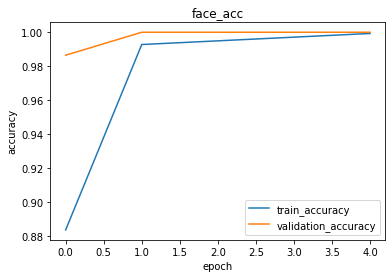

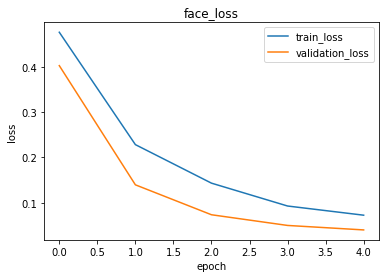

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'face_acc')
plot_loss(history,'face_loss') 